# Multi-task Bayesian Optimization

This tutorial uses synthetic functions to illustrate Bayesian optimization using a multi-task Gaussian Process in Ax. A typical use case is optimizing an expensive-to-evaluate (online) system with supporting (offline) simulations of that system.

Bayesian optimization with a multi-task kernel (Multi-task Bayesian optimization) is described by Swersky et al.  (2013). Letham and Bakshy (2019) describe using multi-task Bayesian optimization to tune a ranking system with a mix of online and offline (simulator) experiments.

This tutorial produces the results of Online Appendix 2 from [that paper](https://arxiv.org/pdf/1904.01049.pdf).

The synthetic problem used here is to maximize the Hartmann 6 function, a classic optimization test problem in 6 dimensions, subject to a constraint on the 2-norm of $x$. Both the objective and the constraint are treated as unknown and are modeled with separate GPs. Both objective and constraint are noisy.

Throughout the optimization we can make nosiy observations directly of the objective and constraint (an online observation), and we can make noisy observations of a biased version of the objective and constraint (offline observations). Bias is simulated by passing the function values through a piecewise linear function. Offline observations are much less time-consuming than online observations, so we wish to use them to improve our ability to optimize the online objective.

In [9]:
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
import time

from ax.core.data import Data
from ax.core.observation import ObservationFeatures, observations_from_data
from ax.core.optimization_config import OptimizationConfig
from ax.core.search_space import SearchSpace
from ax.core.objective import Objective
from ax.runners.synthetic import SyntheticRunner
from ax.modelbridge.random import RandomModelBridge
from ax.core.outcome_constraint import OutcomeConstraint
from ax.core.types import ComparisonOp
from ax.core.parameter import RangeParameter, ParameterType
from ax.core.multi_type_experiment import MultiTypeExperiment
from ax.metrics.hartmann6 import Hartmann6Metric
from ax.metrics.l2norm import L2NormMetric
from ax.modelbridge.factory import get_sobol, get_GPEI, get_MTGP
from ax.core.generator_run import GeneratorRun
from ax.plot.diagnostic import interact_batch_comparison
from ax.utils.notebook.plotting import init_notebook_plotting, render

init_notebook_plotting()

[INFO 04-24 11:03:26] ipy_plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


## 1. Define Metric classes
For this example, the online system is optimizing a Hartmann6 function subject to a 2-norm constraint. The Metric objects for these are directly imported above. We create analagous offline versions of these two metrics which are identical but have a transform applied (a piecewise linear function). We construct Metric objects for each of them.

In [2]:
# Create metrics with artificial offline bias, for both objective and constraint
# by passing the true values through a piecewise linear function.

class OfflineHartmann6Metric(Hartmann6Metric):
    def f(self, x: np.ndarray) -> float:
        raw_res = super().f(x)
        m = -0.35
        if raw_res < m:
            return (1.5* (raw_res - m)) + m
        else:
            return (6.0 * (raw_res - m)) + m

class OfflineL2NormMetric(L2NormMetric):
    def f(self, x: np.ndarray) -> float:
        raw_res = super().f(x)
        m = 1.25
        if raw_res < m:
            return (0.8 * (raw_res - m)) + m
        else:
            return (4 * (raw_res - m)) + m

## 2. Create experiment

A MultiTypeExperiment is used for managing online and offline trials together. It is constructed in several steps:

1. <b> Create the search space</b> - This is done in the usual way.
2. <b>Specify optimization config</b> - Also done in the usual way.
3. <b>Initialize Experiment</b> - In addition to the search_space and optimization_config, specify that "online" is the default trial_type. This is the main trial type for which we're optimizing. Optimization metrics are defined to be for this type and new trials assume this trial type by default.
4. <b>Establish offline trial_type</b> - Register the "offline" trial type and specify how to deploy trials of this type.
5. <b>Add offline metrics</b> - Create the offline metrics and add them to the experiment. When adding the metrics, we need to specify the trial type ("offline") and online metric name it is associated with so the model can link them.

Finally, because this is a synthetic benchmark problem where the true function values are known, we will also register metrics with the true (noiseless) function values for plotting below.

In [3]:
def get_experiment(include_true_metric=True):
    noise_sd = 0.1  # Observations will have this much Normal noise added to them
    
    # 1. Create simple search space for [0,1]^d, d=6
    param_names = [f"x{i}" for i in range(6)]
    parameters=[
        RangeParameter(
            name=param_names[i], parameter_type=ParameterType.FLOAT, lower=0.0, upper=1.0
        )
        for i in range(6)
    ]
    search_space=SearchSpace(parameters=parameters)
    
    # 2. Specify optimization config
    online_objective = Hartmann6Metric("objective", param_names=param_names, noise_sd=noise_sd)
    online_constraint = L2NormMetric("constraint", param_names=param_names, noise_sd=noise_sd)
    opt_config = OptimizationConfig(
        objective=Objective(online_objective, minimize=True),
        outcome_constraints=[OutcomeConstraint(online_constraint, op=ComparisonOp.LEQ, bound=1.25, relative=False)]
    )
    
    # 3. Init experiment
    exp = MultiTypeExperiment(
        name="mt_exp",
        search_space=search_space,
        default_trial_type="online",
        default_runner=SyntheticRunner(),
        optimization_config=opt_config,
    )
    
    # 4. Establish offline trial_type, and how those trials are deployed
    exp.add_trial_type("offline", SyntheticRunner())
    
    # 5. Add offline metrics that provide biased estimates of the online metrics
    offline_objective = OfflineHartmann6Metric("offline_objective", param_names=param_names, noise_sd=noise_sd)
    offline_constraint = OfflineL2NormMetric("offline_constraint", param_names=param_names, noise_sd=noise_sd)
    # Associate each offline metric with corresponding online metric
    exp.add_tracking_metric(metric=offline_objective, trial_type="offline", canonical_name="objective")
    exp.add_tracking_metric(metric=offline_constraint, trial_type="offline", canonical_name="constraint")
    
    # Add a noiseless equivalent for each metric, for tracking the true value of each observation
    # for the purposes of benchmarking.
    if include_true_metric:
        exp.add_tracking_metric(Hartmann6Metric("objective_noiseless", param_names=param_names, noise_sd=0.0), "online")
        exp.add_tracking_metric(L2NormMetric("constraint_noiseless", param_names=param_names, noise_sd=0.0), "online")
    return exp

## 3. Vizualize the simulator bias

These figures compare the online measurements to the offline measurements on a random set of points, for both the objective metric and the constraint metric. You can see the offline measurements are biased but highly correlated. This produces Fig. S3 from the paper.

In [4]:
# Generate 50 points from a Sobol sequence
exp = get_experiment(include_true_metric=False)
s = get_sobol(exp.search_space, scramble=False)
gr = s.gen(50)
# Deploy them both online and offline
exp.new_batch_trial(trial_type="online", generator_run=gr).run()
exp.new_batch_trial(trial_type="offline", generator_run=gr).run()
# Fetch data
data = exp.fetch_data()
observations = observations_from_data(exp, data)
# Plot the arms in batch 0 (online) vs. batch 1 (offline)
render(interact_batch_comparison(observations, exp, 1, 0))

## 4. The Bayesian optimization loop

Here we construct a Bayesian optimization loop that interleaves online and offline batches. The loop defined here is described in Algorithm 1 of the paper. We compare multi-task Bayesian optimization to regular Bayesian optimization using only online observations.

Here we measure performance over 3 repetitions of the loop. Each one takes 1-2 hours so the whole benchmark run will take several hours to complete.

In [5]:
# Settings for the optimization benchmark.

# This should be changed to 50 to reproduce the results from the paper.
n_reps = 3  # Number of repeated experiments, each with independent observation noise

n_init_online = 5  # Size of the quasirandom initialization run online
n_init_offline = 20  # Size of the quasirandom initialization run offline
n_opt_online = 5  # Batch size for BO selected points to be run online
n_opt_offline = 20  # Batch size for BO selected to be run offline
n_batches = 3  # Number of optimized BO batches

#### 4a. Optimization with online observations only
For the online-only case, we run `n_init_online` sobol points followed by `n_batches` batches of `n_opt_online` points selected by the GP. This is a normal Bayesian optimization loop.

In [ ]:
# This function runs a Bayesian optimization loop, making online observations only.
def run_online_only_bo():
    t1 = time.time()
    ### Do BO with online only
    ## Quasi-random initialization
    exp_online = get_experiment()
    m = get_sobol(exp_online.search_space, scramble=False)
    gr = m.gen(n=n_init_online)
    exp_online.new_batch_trial(trial_type="online", generator_run=gr).run()
    ## Do BO
    for b in range(n_batches):
        print('Online-only batch', b, time.time() - t1)
        # Fit the GP
        m = get_GPEI(
            experiment=exp_online,
            data=exp_online.fetch_data(),
            search_space=exp_online.search_space,
        )
        # Generate the new batch
        gr = m.gen(
            n=n_opt_online,
            search_space=exp_online.search_space,
            optimization_config=exp_online.optimization_config,
        )
        exp_online.new_batch_trial(trial_type="online", generator_run=gr).run()
    ## Extract true objective and constraint at each iteration
    df = exp_online.fetch_data().df
    obj = df[df['metric_name'] == 'objective_noiseless']['mean'].values
    con = df[df['metric_name'] == 'constraint_noiseless']['mean'].values
    return obj, con

#### 4b. Multi-task Bayesian optimization
Here we incorporate offline observations to accelerate the optimization, while using the same total number of online observations as in the loop above. The strategy here is that outlined in Algorithm 1 of the paper.

1. <b> Initialization</b> - Run `n_init_online` Sobol points online, and `n_init_offline` Sobol points offline.
2. <b> Fit model </b> - Fit an MTGP to both online and offline observations.
3. <b> Generate candidates </b> - Generate `n_opt_offline` candidates using NEI.
4. <b> Launch offline batch </b> - Run the `n_opt_offline` candidates offline and observe their offline metrics.
5. <b> Update model </b> - Update the MTGP with the new offline observations.
6. <b> Select points for online batch </b> - Select the best (maximum utility) `n_opt_online` of the NEI candidates, after incorporating their offline observations, and run them online.
7. <b> Update model and repeat </b> - Update the model with the online observations, and repeat from step 3 for the next batch.

In [13]:
# Online batches are constructed by selecting the maximum utility points from the offline
# batch, after updating the model with the offline results. This function selects the max utility points according
# to the MTGP predictions.
def max_utility_from_GP(n, m, experiment, search_space, gr):
    obsf = []
    for arm in gr.arms:
        params = deepcopy(arm.parameters)
        params['trial_type'] = 'online'
        obsf.append(ObservationFeatures(parameters=params))
    # Make predictions
    f, cov = m.predict(obsf)
    # Compute expected utility
    mu_c = np.array(f['constraint'])
    sigma_c = np.sqrt(cov['constraint']['constraint'])
    pfeas = norm.cdf((1.25 - mu_c) / sigma_c)
    u = -np.array(f['objective']) * pfeas
    best_arm_indx = np.flip(np.argsort(u))[:n]
    gr_new = GeneratorRun(
        arms = [
            gr.arms[i] for i in best_arm_indx
        ],
        weights = [1.] * n,
    )
    return gr_new

# This function runs a multi-task Bayesian optimization loop, as outlined in Algorithm 1 and above.
def run_mtbo():
    t1 = time.time()
    online_trials = []
    ## 1. Quasi-random initialization, online and offline
    exp_multitask = get_experiment()
    # Online points
    m = get_sobol(exp_multitask.search_space, scramble=False)
    gr = m.gen(
        n=n_init_online,
    )
    tr = exp_multitask.new_batch_trial(trial_type="online", generator_run=gr)
    tr.run()
    online_trials.append(tr.index)
    # Offline points
    m = get_sobol(exp_multitask.search_space, scramble=False)
    gr = m.gen(
        n=n_init_offline,
    )
    exp_multitask.new_batch_trial(trial_type="offline", generator_run=gr).run()
    ## Do BO
    for b in range(n_batches):
        print('Multi-task batch', b, time.time() - t1)
        # (2 / 7). Fit the MTGP
        m = get_MTGP(
            experiment=exp_multitask,
            data=exp_multitask.fetch_data(),
            search_space=exp_multitask.search_space,
        )

        # 3. Finding the best points for the online task
        gr = m.gen(
            n=n_opt_offline,
            optimization_config=exp_multitask.optimization_config,
            fixed_features=ObservationFeatures(parameters={'trial_type': 'online'}),
        )

        # 4. But launch them offline
        exp_multitask.new_batch_trial(trial_type="offline", generator_run=gr).run()
        
        # 5. Update the model
        m = get_MTGP(
            experiment=exp_multitask,
            data=exp_multitask.fetch_data(),
            search_space=exp_multitask.search_space,
        )
        
        # 6. Select max-utility points from the offline batch to generate an online batch
        gr = max_utility_from_GP(
            n=n_opt_online,
            m=m,
            experiment=exp_multitask,
            search_space=exp_multitask.search_space,
            gr=gr,
        )
        tr = exp_multitask.new_batch_trial(trial_type="online", generator_run=gr)
        tr.run()
        online_trials.append(tr.index)
    # Extract true objective at each online iteration for creating benchmark plot
    obj = np.array([])
    con = np.array([])
    for tr in online_trials:
        df_t = exp_multitask.trials[tr].fetch_data().df
        df_tobj = df_t[df_t['metric_name'] == 'objective_noiseless']
        obj = np.hstack((obj, df_tobj['mean'].values))
        df_tcon = df_t[df_t['metric_name'] == 'constraint_noiseless']
        con = np.hstack((con, df_tcon['mean'].values))
    return obj, con

#### 4c. Run both loops
Run both Bayesian optimization loops and aggregate results.

In [ ]:
runners = {
    'GP, online only': run_online_only_bo,
    'MTGP, Algorithm 1': run_mtbo,
}
iteration_objectives = {k: [] for k in runners}
iteration_constraints = {k: [] for k in runners}
for rep in range(n_reps):
    print('Running rep', rep)
    for k, r in runners.items():
        obj, con = r()
        iteration_objectives[k].append(obj)
        iteration_constraints[k].append(con)

for k, v in iteration_objectives.items():
    iteration_objectives[k] = np.array(v)
    iteration_constraints[k] = np.array(iteration_constraints[k])

## 5. Plot results

We plot the cumulative best point found by each online iteration of the optimization for each of the methods. We see that despite the bias in the offline observations, incorporating them into the optimziation with the multi-task model allows the optimization to converge to the optimal point much faster. With n_reps=50, this generates Fig. S4 of the paper.

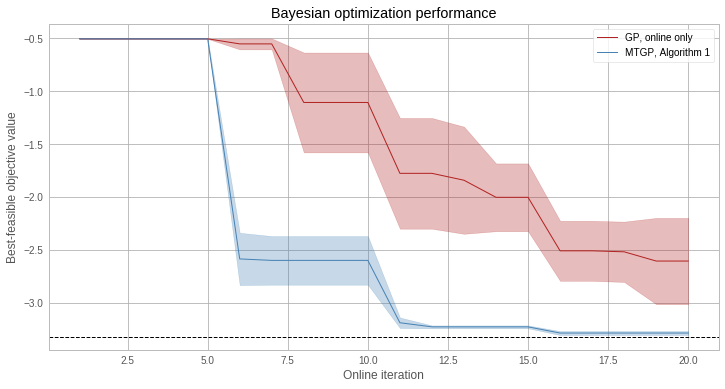

In [23]:
means = {}
sems = {}
for m, obj in iteration_objectives.items():
    x = obj.copy()
    z = iteration_constraints[m].copy()
    x[z > 1.25] = np.Inf  # The value of infeasible points
    best_obj = np.array([np.minimum.accumulate(obj_i) for obj_i in x])
    means[m] = best_obj.mean(axis=0)
    sems[m] = best_obj.std(axis=0) / np.sqrt(best_obj.shape[0])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
x = np.arange(1, len(means['GP, online only']) + 1)
colors = ['firebrick', 'steelblue']
methods = ['GP, online only', 'MTGP, Algorithm 1']
for i, m in enumerate(methods):
    ax.plot(x, means[m], ls='-', c=colors[i])
    ax.fill_between(x, means[m] - 2 * sems[m], means[m] + 2 * sems[m], color=colors[i], alpha=0.3)
ax.legend(methods)
ax.axhline(y=-3.32237, c='k', ls='--')  # Actual optimum for this problem
ax.set_xlabel('Online iteration')
ax.set_ylabel('Best-feasible objective value')
ax.set_title('Bayesian optimization performance');

#### References
Benjamin Letham and Eytan Bakshy. Bayesian optimization for policy search via online-offline experimentation. _arXiv preprint arXiv:1603.09326_, 2019.

Kevin Swersky, Jasper Snoek, and Ryan P Adams.  Multi-task Bayesian optimization.  In _Advances in Neural Information Processing Systems_ 26, NIPS, pages 2004–2012, 2013.